In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from typing import Dict, Tuple, List
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule, seed_everything
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score, MetricCollection, Precision, Recall
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np

from energizer import AccumulatorStrategy, NoAccumulatorStrategy, Trainer, MCAccumulatorStrategy
from energizer.acquisition_functions import entropy, least_confidence, margin_confidence, expected_margin_confidence, expected_entropy, bald

Load and preprocess data, and prepare dataloaders

In [3]:
# load and preprocess datasets
data_dir = "./data"
preprocessing_pipe = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_set = MNIST(data_dir, train=True, download=True, transform=preprocessing_pipe)
test_set = MNIST(data_dir, train=False, download=True, transform=preprocessing_pipe)
train_set, val_set = random_split(train_set, [55000, 5000])

# create dataloaders
batch_size = 32
eval_batch_size = 128  # this is use when evaluating on the pool too
train_dl = DataLoader(train_set, batch_size=batch_size, num_workers=os.cpu_count())
val_dl = DataLoader(val_set, batch_size=eval_batch_size, num_workers=os.cpu_count())
test_dl = DataLoader(test_set, batch_size=eval_batch_size, num_workers=os.cpu_count())

Define the model

In [4]:
class MNISTModel(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.Linear(128, 10),
        )
        for stage in ("train", "val", "test"):
            setattr(self, f"{stage}_accuracy", Accuracy())

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def loss(self, logits: Tensor, targets: Tensor) -> Tensor:
        return F.cross_entropy(logits, targets)

    def common_step(self, batch: Tuple[Tensor, Tensor], stage: str) -> Dict[str, Tensor]:
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        accuracy = getattr(self, f"{stage}_accuracy")(logits, y)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/accuracy", accuracy, on_epoch=True, on_step=True, prog_bar=True)
        return {"loss": loss, "logits": logits}

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.common_step(batch, "train")

    def validation_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.common_step(batch, "val")

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.common_step(batch, "test")

    def configure_optimizers(self) -> None:
        return torch.optim.SGD(self.parameters(), lr=0.01)

### Define active learning strategies

We implement the following strategies:

- `RandomStrategy`: selects random instances from the pool. Therefore, it does not need to run any computation on the pool. Thus, we inherit from the `NoAccumulatorStrategy` base class so that we can speed up the computations. As it does not need to run on the pool so we do not need to implement the `pool_step` method, we only need to implement the `query` method.

- `EntropyStrategy`: selects instances that the model is most uncertain about, where the uncertainty is defined as the entropy of the predicted probability distribution over the classes. It needs to run operations on the pool, thus we inherit from the `AccumulatorStrategy` base class. Since it needs to run on the pool, we need to implement the `pool_step` method, but we do not need to implement `query` as `AccumulatorStrategy` knows how to compute the top-k operation and return the indices.

- `LeastConfidenceStrategy`: selects instances that the model is most uncertain about, where the uncertainty is defined as the value of the smallest class probability. It needs to run operations on the pool like the `EntropyStrategy` 

- `MarginConfidenceStrategy`: selects instances that the model is most uncertain about, where the uncertainty is defined as the difference between the first and the second biggest highest class probabilities. It needs to run operations on the pool like the `EntropyStrategy` 


Note that both strategies are already available in the library directly.

In [72]:
class RandomStrategy(NoAccumulatorStrategy):
    def query(self) -> List[int]:
        pool_size = self.trainer.datamodule.pool_size
        return np.random.randint(low=0, high=pool_size, size=self.query_size).tolist()


class EntropyStrategy(AccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        """NOTE: since we are defining the `pool_step` ourselves, we can define
        the logic to unpack the batch directly here. When using a pre-defined strategy,
        we need to implement the `get_inputs_from_batch` hook, unless the forward
        method of the model you defined is able to run on the batch "as-is" from the
        dataloader.
        """
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = entropy(logits)
        return scores

class LeastConfidenceStrategy(AccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = least_confidence(logits)
        return scores

class MarginStrategy(AccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = margin_confidence(logits)
        return scores

class ExpectedMarginStrategy(MCAccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = expected_margin_confidence(logits)
        return scores

class ExpectedEntropyStrategy(MCAccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = expected_entropy(logits)
        return scores

class BALDStrategy(MCAccumulatorStrategy):
    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        x, _ = batch
        logits = self(x)
        # use the entropy scoring function
        scores = bald(logits)
        return scores

In [6]:
# instantiate model
model = MNISTModel()

NOTE: when passing a model to build a strategy, internally a `deepcopy` will be created. This is done to avoid modifying the model state and passing it around when trying other strategies. It avoids messing up benchmarks

In [73]:
random_strategy = RandomStrategy(model)
entropy_strategy = EntropyStrategy(model)
leastconfidence_strategy = LeastConfidenceStrategy(model)
margin_strategy = MarginStrategy(model)
expected_entropy_strategy = ExpectedEntropyStrategy(model)
expected_margin_strategy = ExpectedMarginStrategy(model)
bald_strategy = BALDStrategy(model)

strategies = [
    random_strategy,
    entropy_strategy,
    leastconfidence_strategy,
    margin_strategy,
    expected_entropy_strategy,
    expected_margin_strategy,
    bald_strategy,
]

The forward pass of the strategy internally calls the forward of the underlying module.

In [8]:
x = next(iter(train_dl))[0]

model.eval()
for strategy in strategies:
    strategy.eval()
    
out_model = model(x)
out_random = random_strategy(x)
out_entropy = entropy_strategy(x)

model.train()
random_strategy.train()
entropy_strategy.train()

assert torch.all(out_model == out_random)
assert torch.all(out_model == out_entropy)

out_model.shape, out_random.shape, out_entropy.shape

(torch.Size([32, 10]), torch.Size([32, 10]), torch.Size([32, 10]))

## Active fit

For clarity let's pack the trainer kwargs in a dictionary

In [9]:
trainer_kwargs = {
    "query_size": 10,  # 50 new instances will be queried at each iteration
    "max_epochs": 3,  # the underlying model will be fit for 3 epochs
    "max_labelling_epochs": 50,  # how many times to run the active learning loop
    "accelerator": "gpu",  # use the gpu
    "test_after_labelling": True,  # since we have a test set, we test after each labelling iteration
    "limit_val_batches": 0,  # do not validate
    "log_every_n_steps": 1,  # we will have a few batches while training, so log on each
}

results_dict = {}

### Random strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=random_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [11]:
random_df = results.to_pandas()
results_dict["random"] = random_df
random_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.297897,0.1394
1,10,2.281411,0.1457
2,20,2.275584,0.1796
3,30,2.276633,0.2287
4,40,2.279635,0.1874
5,50,2.284646,0.2117
6,60,2.270094,0.1196
7,70,2.304212,0.1012
8,80,2.264733,0.1011
9,90,2.256096,0.1483


### Entropy strategy

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=entropy_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [13]:
entropy_df = results.to_pandas()
results_dict["entropy"] = entropy_df
entropy_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.297897,0.1394
1,10,2.315490,0.1230
2,20,2.318302,0.1135
3,30,2.321230,0.1809
4,40,2.424509,0.2061
5,50,2.407376,0.1136
6,60,2.388334,0.1161
7,70,2.505753,0.1136
8,80,2.521131,0.1135
9,90,2.479761,0.1136


### Least confidence strategy

In [22]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=leastconfidence_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[2022-09-05 17:29:27] energizer/DETAIL ~ trainer:267$ Trainer: trainer active_fit stage
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | model          | Sequential | 184 K 
1 | train_accuracy | Accuracy   | 0     
2 | val_accuracy   | Accuracy   | 0     
3 | test_accuracy  | Accuracy   | 0     
----------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.738     Total estimated model params size (MB)
[2022-09-05 17:29:28] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


-------------------------Labelling Iteration 0--------------------------


[2022-09-05 17:29:28] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13940000534057617    │
│      test/loss_epoch      │    2.2978968620300293     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:29] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:29:32] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:29:32] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:29:32] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-05 17:29:32] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:29:32] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:29:34] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.15109999477863312    │
│      test/loss_epoch      │    2.3368868827819824     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:35] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:29:38] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:29:38] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:29:38] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20



-------------------------Labelling Iteration 2--------------------------


[2022-09-05 17:29:38] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:29:38] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:29:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1151999980211258     │
│      test/loss_epoch      │    2.3138234615325928     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:41] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:29:44] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:29:44] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:29:44] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54970
total_data_size: 55000
train_size: 30



-------------------------Labelling Iteration 3--------------------------


[2022-09-05 17:29:44] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:29:44] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:29:46] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.20100000500679016    │
│      test/loss_epoch      │    2.3250701427459717     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:47] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:29:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:29:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:29:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54960
total_data_size: 55000
train_size: 40



-------------------------Labelling Iteration 4--------------------------


[2022-09-05 17:29:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:29:49] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:29:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2021999955177307     │
│      test/loss_epoch      │     2.346604108810425     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:52] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:29:55] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:29:55] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:29:55] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54950
total_data_size: 55000
train_size: 50



-------------------------Labelling Iteration 5--------------------------


[2022-09-05 17:29:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:29:55] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:29:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.10289999842643738    │
│      test/loss_epoch      │     2.379779100418091     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:29:58] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:00] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:00] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:00] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54940
total_data_size: 55000
train_size: 60



-------------------------Labelling Iteration 6--------------------------


[2022-09-05 17:30:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:00] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2076999992132187     │
│      test/loss_epoch      │     2.376084089279175     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:03] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:06] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:06] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:06] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54930
total_data_size: 55000
train_size: 70



-------------------------Labelling Iteration 7--------------------------


[2022-09-05 17:30:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:06] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:08] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2797999978065491     │
│      test/loss_epoch      │     2.377094030380249     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:09] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:12] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:12] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:12] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54920
total_data_size: 55000
train_size: 80



-------------------------Labelling Iteration 8--------------------------


[2022-09-05 17:30:12] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:12] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:14] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2094999998807907     │
│      test/loss_epoch      │     2.382188081741333     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:15] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:18] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:18] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:18] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 3
pool_size: 54910
total_data_size: 55000
train_size: 90



-------------------------Labelling Iteration 9--------------------------


[2022-09-05 17:30:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2076999992132187     │
│      test/loss_epoch      │    2.3694357872009277     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:21] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:23] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:23] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:23] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54900
total_data_size: 55000
train_size: 100



-------------------------Labelling Iteration 10-------------------------


[2022-09-05 17:30:23] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:23] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2777999937534332     │
│      test/loss_epoch      │    2.4017603397369385     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:26] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54890
total_data_size: 55000
train_size: 110



-------------------------Labelling Iteration 11-------------------------


[2022-09-05 17:30:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2101999968290329     │
│      test/loss_epoch      │     2.37914776802063      │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:32] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54880
total_data_size: 55000
train_size: 120



-------------------------Labelling Iteration 12-------------------------


[2022-09-05 17:30:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:36] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.23319999873638153    │
│      test/loss_epoch      │    2.3599648475646973     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:38] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:40] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:40] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:40] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54870
total_data_size: 55000
train_size: 130



-------------------------Labelling Iteration 13-------------------------


[2022-09-05 17:30:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:40] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:42] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.09000000357627869    │
│      test/loss_epoch      │    2.4674956798553467     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:43] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:46] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:46] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:46] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54860
total_data_size: 55000
train_size: 140



-------------------------Labelling Iteration 14-------------------------


[2022-09-05 17:30:46] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:46] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:48] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.12060000002384186    │
│      test/loss_epoch      │    2.4021875858306885     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:49] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54850
total_data_size: 55000
train_size: 150



-------------------------Labelling Iteration 15-------------------------


[2022-09-05 17:30:52] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:52] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:53] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.17339999973773956    │
│      test/loss_epoch      │    2.3930087089538574     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:30:55] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:30:57] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:30:57] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:30:57] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54840
total_data_size: 55000
train_size: 160



-------------------------Labelling Iteration 16-------------------------


[2022-09-05 17:30:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:30:57] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:30:59] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.22619999945163727    │
│      test/loss_epoch      │     2.406629800796509     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:00] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:03] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:03] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:03] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54830
total_data_size: 55000
train_size: 170



-------------------------Labelling Iteration 17-------------------------


[2022-09-05 17:31:03] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:03] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:05] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.19820000231266022    │
│      test/loss_epoch      │    2.4068405628204346     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:06] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:09] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:09] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:09] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54820
total_data_size: 55000
train_size: 180



-------------------------Labelling Iteration 18-------------------------


[2022-09-05 17:31:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:09] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:10] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2676999866962433     │
│      test/loss_epoch      │     2.391103982925415     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:12] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:14] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:14] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:14] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54810
total_data_size: 55000
train_size: 190



-------------------------Labelling Iteration 19-------------------------


[2022-09-05 17:31:14] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:14] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:16] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2619999945163727     │
│      test/loss_epoch      │    2.3656392097473145     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:17] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:20] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:20] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:20] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54800
total_data_size: 55000
train_size: 200



-------------------------Labelling Iteration 20-------------------------


[2022-09-05 17:31:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:20] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:22] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.18209999799728394    │
│      test/loss_epoch      │    2.3807623386383057     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:23] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:26] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:26] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:26] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54790
total_data_size: 55000
train_size: 210



-------------------------Labelling Iteration 21-------------------------


[2022-09-05 17:31:26] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:26] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:28] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3720000088214874     │
│      test/loss_epoch      │    2.3541951179504395     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:29] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:31] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:31] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:31] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 7
pool_size: 54780
total_data_size: 55000
train_size: 220



-------------------------Labelling Iteration 22-------------------------


[2022-09-05 17:31:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:31] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:33] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.34929999709129333    │
│      test/loss_epoch      │     2.365677833557129     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:34] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:37] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:37] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:37] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54770
total_data_size: 55000
train_size: 230



-------------------------Labelling Iteration 23-------------------------


[2022-09-05 17:31:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:37] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:39] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3107999861240387     │
│      test/loss_epoch      │     2.388442039489746     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:40] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:43] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:43] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:43] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54760
total_data_size: 55000
train_size: 240



-------------------------Labelling Iteration 24-------------------------


[2022-09-05 17:31:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:43] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:45] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.41609999537467957    │
│      test/loss_epoch      │     2.352058172225952     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:46] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:31:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:31:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:31:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54750
total_data_size: 55000
train_size: 250



-------------------------Labelling Iteration 25-------------------------


[2022-09-05 17:31:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:49] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3677999973297119     │
│      test/loss_epoch      │     2.344339609146118     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:52] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19682a35e0>
Traceback (most recent call last):
  File "/home/pl487/.conda/envs/energizer-dev/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19682a35e0>
self._shutdown_workers()Traceback (most recent call last):

  File "/home/pl487/.conda/envs/energizer-dev/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/pl487/.conda/envs/energizer-dev/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():  File "/home/pl487/.conda/envs/energizer-dev/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/pl487/.conda/envs/energizer-dev/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
  F

-------------------------Labelling Iteration 26-------------------------


[2022-09-05 17:31:56] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:31:56] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:31:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.18940000236034393    │
│      test/loss_epoch      │     2.356593608856201     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:31:59] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:02] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:02] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:02] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54730
total_data_size: 55000
train_size: 270



-------------------------Labelling Iteration 27-------------------------


[2022-09-05 17:32:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:02] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3734999895095825     │
│      test/loss_epoch      │    2.3147590160369873     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:05] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:07] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:07] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:07] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54720
total_data_size: 55000
train_size: 280



-------------------------Labelling Iteration 28-------------------------


[2022-09-05 17:32:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:07] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3594000041484833     │
│      test/loss_epoch      │     2.304394006729126     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:11] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:13] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:13] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:13] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54710
total_data_size: 55000
train_size: 290



-------------------------Labelling Iteration 29-------------------------


[2022-09-05 17:32:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:13] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:15] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.17499999701976776    │
│      test/loss_epoch      │    2.3891448974609375     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:16] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:19] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:19] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:19] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54700
total_data_size: 55000
train_size: 300



-------------------------Labelling Iteration 30-------------------------


[2022-09-05 17:32:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:19] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:21] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.39800000190734863    │
│      test/loss_epoch      │    2.3171637058258057     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:22] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:25] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:25] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:25] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54690
total_data_size: 55000
train_size: 310



-------------------------Labelling Iteration 31-------------------------


[2022-09-05 17:32:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:25] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:27] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.45489999651908875    │
│      test/loss_epoch      │    2.3026340007781982     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:28] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:31] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:31] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:31] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54680
total_data_size: 55000
train_size: 320



-------------------------Labelling Iteration 32-------------------------


[2022-09-05 17:32:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:31] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:33] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4223000109195709     │
│      test/loss_epoch      │    2.2765426635742188     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:34] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:36] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:36] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:36] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54670
total_data_size: 55000
train_size: 330



-------------------------Labelling Iteration 33-------------------------


[2022-09-05 17:32:36] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:36] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:38] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2915000021457672     │
│      test/loss_epoch      │     2.268507957458496     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:40] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:42] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:42] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:42] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54660
total_data_size: 55000
train_size: 340



-------------------------Labelling Iteration 34-------------------------


[2022-09-05 17:32:42] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:42] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:44] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2872999906539917     │
│      test/loss_epoch      │    2.2679405212402344     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:46] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:48] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:48] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:48] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 11
pool_size: 54650
total_data_size: 55000
train_size: 350



-------------------------Labelling Iteration 35-------------------------


[2022-09-05 17:32:48] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:48] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:50] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │     0.387800008058548     │
│      test/loss_epoch      │     2.243809700012207     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:51] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:32:54] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:32:54] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:32:54] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54640
total_data_size: 55000
train_size: 360



-------------------------Labelling Iteration 36-------------------------


[2022-09-05 17:32:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:32:54] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:32:56] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2295999974012375     │
│      test/loss_epoch      │     2.241969108581543     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:32:57] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:00] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:00] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:00] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54630
total_data_size: 55000
train_size: 370



-------------------------Labelling Iteration 37-------------------------


[2022-09-05 17:33:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:00] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3431999981403351     │
│      test/loss_epoch      │     2.232809543609619     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:03] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:06] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:06] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:06] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54620
total_data_size: 55000
train_size: 380



-------------------------Labelling Iteration 38-------------------------


[2022-09-05 17:33:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:06] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:08] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.31189998984336853    │
│      test/loss_epoch      │    2.2261319160461426     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:09] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:12] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:12] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:12] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54610
total_data_size: 55000
train_size: 390



-------------------------Labelling Iteration 39-------------------------


[2022-09-05 17:33:12] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:12] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:14] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14139999449253082    │
│      test/loss_epoch      │    2.2390880584716797     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:15] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:18] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:18] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:18] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54600
total_data_size: 55000
train_size: 400



-------------------------Labelling Iteration 40-------------------------


[2022-09-05 17:33:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4154999852180481     │
│      test/loss_epoch      │     2.214344024658203     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:21] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:23] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:23] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:23] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54590
total_data_size: 55000
train_size: 410



-------------------------Labelling Iteration 41-------------------------


[2022-09-05 17:33:23] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:23] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.37130001187324524    │
│      test/loss_epoch      │     2.213609218597412     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:27] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54580
total_data_size: 55000
train_size: 420



-------------------------Labelling Iteration 42-------------------------


[2022-09-05 17:33:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.08969999849796295    │
│      test/loss_epoch      │     2.272613763809204     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:33] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54570
total_data_size: 55000
train_size: 430



-------------------------Labelling Iteration 43-------------------------


[2022-09-05 17:33:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3407000005245209     │
│      test/loss_epoch      │     2.198895215988159     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:39] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54560
total_data_size: 55000
train_size: 440



-------------------------Labelling Iteration 44-------------------------


[2022-09-05 17:33:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4278999865055084     │
│      test/loss_epoch      │    2.1959030628204346     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:45] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:47] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:47] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:47] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54550
total_data_size: 55000
train_size: 450



-------------------------Labelling Iteration 45-------------------------


[2022-09-05 17:33:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:47] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21699999272823334    │
│      test/loss_epoch      │     2.233085870742798     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:50] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:53] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:53] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:53] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54540
total_data_size: 55000
train_size: 460



-------------------------Labelling Iteration 46-------------------------


[2022-09-05 17:33:53] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:53] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:33:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.27630001306533813    │
│      test/loss_epoch      │     2.175872564315796     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:33:56] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:33:59] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:33:59] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:33:59] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54530
total_data_size: 55000
train_size: 470



-------------------------Labelling Iteration 47-------------------------


[2022-09-05 17:33:59] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:33:59] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:34:01] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.39739999175071716    │
│      test/loss_epoch      │     2.182389497756958     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:02] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:34:05] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:34:05] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:34:05] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 15
pool_size: 54520
total_data_size: 55000
train_size: 480



-------------------------Labelling Iteration 48-------------------------


[2022-09-05 17:34:05] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:34:05] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:34:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4138000011444092     │
│      test/loss_epoch      │     2.177879810333252     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:08] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:34:11] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:34:11] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:34:11] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54510
total_data_size: 55000
train_size: 490



-------------------------Labelling Iteration 49-------------------------


[2022-09-05 17:34:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:34:11] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:34:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4115999937057495     │
│      test/loss_epoch      │     2.178447961807251     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:14] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:34:17] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:34:17] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:34:17] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54500
total_data_size: 55000
train_size: 500

[2022-09-05 17:34:17] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:34:17] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


Training: 16it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:34:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3833000063896179     │
│      test/loss_epoch      │    2.1703319549560547     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:21] energizer/INFO ~ trainer:462$ Using `LeastConfidenceStrategy`


In [23]:
leastconfidence_df = results.to_pandas()
results_dict["leastconfidence"] = leastconfidence_df
leastconfidence_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.297897,0.1394
1,10,2.336887,0.1511
2,20,2.313823,0.1152
3,30,2.325070,0.2010
4,40,2.346604,0.2022
5,50,2.379779,0.1029
6,60,2.376084,0.2077
7,70,2.377094,0.2798
8,80,2.382188,0.2095
9,90,2.369436,0.2077


### Margin strategy

In [26]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=margin_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[2022-09-05 17:34:50] energizer/DETAIL ~ trainer:267$ Trainer: trainer active_fit stage
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | model          | Sequential | 184 K 
1 | train_accuracy | Accuracy   | 0     
2 | val_accuracy   | Accuracy   | 0     
3 | test_accuracy  | Accuracy   | 0     
----------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.738     Total estimated model params size (MB)
[2022-09-05 17:34:50] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


-------------------------Labelling Iteration 0--------------------------


[2022-09-05 17:34:50] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13940000534057617    │
│      test/loss_epoch      │    2.2978968620300293     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:51] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:34:55] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:34:55] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:34:55] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-05 17:34:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:34:55] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:34:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2175000011920929     │
│      test/loss_epoch      │    2.3163020610809326     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:34:58] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:01] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:01] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:01] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20



-------------------------Labelling Iteration 2--------------------------


[2022-09-05 17:35:01] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:01] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:03] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.10320000350475311    │
│      test/loss_epoch      │    2.3021411895751953     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:04] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:07] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:07] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:07] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54970
total_data_size: 55000
train_size: 30



-------------------------Labelling Iteration 3--------------------------


[2022-09-05 17:35:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:07] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.17970000207424164    │
│      test/loss_epoch      │    2.3112759590148926     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:10] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:13] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:13] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:13] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54960
total_data_size: 55000
train_size: 40



-------------------------Labelling Iteration 4--------------------------


[2022-09-05 17:35:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:13] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:15] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21160000562667847    │
│      test/loss_epoch      │    2.3303630352020264     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:16] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:19] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:19] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:19] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54950
total_data_size: 55000
train_size: 50



-------------------------Labelling Iteration 5--------------------------


[2022-09-05 17:35:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:19] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1655000001192093     │
│      test/loss_epoch      │    2.3102898597717285     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:21] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:24] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:24] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:24] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54940
total_data_size: 55000
train_size: 60



-------------------------Labelling Iteration 6--------------------------


[2022-09-05 17:35:24] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:24] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:26] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.18559999763965607    │
│      test/loss_epoch      │     2.300184726715088     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:27] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:30] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:30] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:30] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54930
total_data_size: 55000
train_size: 70



-------------------------Labelling Iteration 7--------------------------


[2022-09-05 17:35:30] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:30] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1143999993801117     │
│      test/loss_epoch      │     2.31512188911438      │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:33] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54920
total_data_size: 55000
train_size: 80



-------------------------Labelling Iteration 8--------------------------


[2022-09-05 17:35:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11630000174045563    │
│      test/loss_epoch      │    2.3078725337982178     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:38] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 3
pool_size: 54910
total_data_size: 55000
train_size: 90



-------------------------Labelling Iteration 9--------------------------


[2022-09-05 17:35:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11349999904632568    │
│      test/loss_epoch      │     2.293342351913452     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:44] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:47] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:47] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:47] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54900
total_data_size: 55000
train_size: 100



-------------------------Labelling Iteration 10-------------------------


[2022-09-05 17:35:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:47] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:48] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1143999993801117     │
│      test/loss_epoch      │     2.343106746673584     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:49] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54890
total_data_size: 55000
train_size: 110



-------------------------Labelling Iteration 11-------------------------


[2022-09-05 17:35:52] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:52] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.20880000293254852    │
│      test/loss_epoch      │     2.289201021194458     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:35:55] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:35:58] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:35:58] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:35:58] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54880
total_data_size: 55000
train_size: 120



-------------------------Labelling Iteration 12-------------------------


[2022-09-05 17:35:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:35:58] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:35:59] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21320000290870667    │
│      test/loss_epoch      │     2.258373737335205     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:00] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:03] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:03] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:03] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54870
total_data_size: 55000
train_size: 130



-------------------------Labelling Iteration 13-------------------------


[2022-09-05 17:36:03] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:03] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:05] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.09759999811649323    │
│      test/loss_epoch      │    2.2968387603759766     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:06] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:09] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:09] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:09] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54860
total_data_size: 55000
train_size: 140



-------------------------Labelling Iteration 14-------------------------


[2022-09-05 17:36:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:09] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21070000529289246    │
│      test/loss_epoch      │     2.246317148208618     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:12] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:15] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:15] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:15] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54850
total_data_size: 55000
train_size: 150



-------------------------Labelling Iteration 15-------------------------


[2022-09-05 17:36:15] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:15] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:16] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.23510000109672546    │
│      test/loss_epoch      │     2.24277663230896      │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:18] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:20] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:20] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:20] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54840
total_data_size: 55000
train_size: 160



-------------------------Labelling Iteration 16-------------------------


[2022-09-05 17:36:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:20] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:22] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.22859999537467957    │
│      test/loss_epoch      │     2.237531900405884     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:23] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:26] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:26] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:26] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54830
total_data_size: 55000
train_size: 170



-------------------------Labelling Iteration 17-------------------------


[2022-09-05 17:36:26] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:26] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:28] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.29170000553131104    │
│      test/loss_epoch      │    2.2123851776123047     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:29] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:32] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:32] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:32] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54820
total_data_size: 55000
train_size: 180



-------------------------Labelling Iteration 18-------------------------


[2022-09-05 17:36:32] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:32] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:33] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21709999442100525    │
│      test/loss_epoch      │     2.209491014480591     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:35] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:37] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:37] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:37] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54810
total_data_size: 55000
train_size: 190



-------------------------Labelling Iteration 19-------------------------


[2022-09-05 17:36:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:37] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:39] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2526000142097473     │
│      test/loss_epoch      │    2.2041707038879395     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:40] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:43] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:43] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:43] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54800
total_data_size: 55000
train_size: 200



-------------------------Labelling Iteration 20-------------------------


[2022-09-05 17:36:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:43] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:45] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.33250001072883606    │
│      test/loss_epoch      │    2.2021193504333496     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:46] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54790
total_data_size: 55000
train_size: 210



-------------------------Labelling Iteration 21-------------------------


[2022-09-05 17:36:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:49] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3257000148296356     │
│      test/loss_epoch      │     2.202380657196045     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:52] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:36:55] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:36:55] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:36:55] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 7
pool_size: 54780
total_data_size: 55000
train_size: 220



-------------------------Labelling Iteration 22-------------------------


[2022-09-05 17:36:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:36:55] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:36:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.36640000343322754    │
│      test/loss_epoch      │     2.197443962097168     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:36:58] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:00] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:00] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:00] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54770
total_data_size: 55000
train_size: 230



-------------------------Labelling Iteration 23-------------------------


[2022-09-05 17:37:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:00] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.47029998898506165    │
│      test/loss_epoch      │      2.1827232837677      │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:03] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:06] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:06] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:06] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54760
total_data_size: 55000
train_size: 240



-------------------------Labelling Iteration 24-------------------------


[2022-09-05 17:37:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:06] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:08] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.35839998722076416    │
│      test/loss_epoch      │    2.1847689151763916     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:09] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:12] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:12] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:12] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54750
total_data_size: 55000
train_size: 250



-------------------------Labelling Iteration 25-------------------------


[2022-09-05 17:37:12] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:12] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:14] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3869999945163727     │
│      test/loss_epoch      │    2.1869912147521973     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:15] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:18] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:18] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:18] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54740
total_data_size: 55000
train_size: 260



-------------------------Labelling Iteration 26-------------------------


[2022-09-05 17:37:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14949999749660492    │
│      test/loss_epoch      │    2.1733436584472656     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:21] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:23] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:23] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:23] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54730
total_data_size: 55000
train_size: 270



-------------------------Labelling Iteration 27-------------------------


[2022-09-05 17:37:23] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:23] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4449999928474426     │
│      test/loss_epoch      │     2.164233684539795     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:27] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54720
total_data_size: 55000
train_size: 280



-------------------------Labelling Iteration 28-------------------------


[2022-09-05 17:37:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.42089998722076416    │
│      test/loss_epoch      │    2.1653923988342285     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:32] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54710
total_data_size: 55000
train_size: 290



-------------------------Labelling Iteration 29-------------------------


[2022-09-05 17:37:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.19820000231266022    │
│      test/loss_epoch      │    2.1901533603668213     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:38] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54700
total_data_size: 55000
train_size: 300



-------------------------Labelling Iteration 30-------------------------


[2022-09-05 17:37:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4991999864578247     │
│      test/loss_epoch      │    2.1580328941345215     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:44] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:47] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:47] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:47] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54690
total_data_size: 55000
train_size: 310



-------------------------Labelling Iteration 31-------------------------


[2022-09-05 17:37:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:47] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.39340001344680786    │
│      test/loss_epoch      │    2.1529085636138916     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:50] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54680
total_data_size: 55000
train_size: 320



-------------------------Labelling Iteration 32-------------------------


[2022-09-05 17:37:52] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:52] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:37:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5198000073432922     │
│      test/loss_epoch      │    2.1543381214141846     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:37:56] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:37:58] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:37:58] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:37:58] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54670
total_data_size: 55000
train_size: 330



-------------------------Labelling Iteration 33-------------------------


[2022-09-05 17:37:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:37:58] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3402000069618225     │
│      test/loss_epoch      │    2.1342570781707764     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:01] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:04] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:04] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:04] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54660
total_data_size: 55000
train_size: 340



-------------------------Labelling Iteration 34-------------------------


[2022-09-05 17:38:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:04] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4277999997138977     │
│      test/loss_epoch      │     2.130293369293213     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:07] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:11] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:11] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:11] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 11
pool_size: 54650
total_data_size: 55000
train_size: 350



-------------------------Labelling Iteration 35-------------------------


[2022-09-05 17:38:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:11] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.6187999844551086     │
│      test/loss_epoch      │     2.130708932876587     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:14] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:17] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:17] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:17] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54640
total_data_size: 55000
train_size: 360



-------------------------Labelling Iteration 36-------------------------


[2022-09-05 17:38:17] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:17] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4296000003814697     │
│      test/loss_epoch      │    2.1190168857574463     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:20] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:23] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:23] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:23] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54630
total_data_size: 55000
train_size: 370



-------------------------Labelling Iteration 37-------------------------


[2022-09-05 17:38:23] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:23] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5537999868392944     │
│      test/loss_epoch      │     2.120575428009033     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:26] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:28] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54620
total_data_size: 55000
train_size: 380



-------------------------Labelling Iteration 38-------------------------


[2022-09-05 17:38:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.6265000104904175     │
│      test/loss_epoch      │     2.114732503890991     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:32] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:34] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:34] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:34] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54610
total_data_size: 55000
train_size: 390



-------------------------Labelling Iteration 39-------------------------


[2022-09-05 17:38:34] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:34] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.26980000734329224    │
│      test/loss_epoch      │     2.115771770477295     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:38] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:40] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54600
total_data_size: 55000
train_size: 400



-------------------------Labelling Iteration 40-------------------------


[2022-09-05 17:38:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5479000210762024     │
│      test/loss_epoch      │    2.1101670265197754     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:44] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:46] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:46] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:46] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54590
total_data_size: 55000
train_size: 410



-------------------------Labelling Iteration 41-------------------------


[2022-09-05 17:38:46] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:46] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │     0.616599977016449     │
│      test/loss_epoch      │     2.098029375076294     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:50] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54580
total_data_size: 55000
train_size: 420



-------------------------Labelling Iteration 42-------------------------


[2022-09-05 17:38:53] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:53] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:38:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.4375999867916107     │
│      test/loss_epoch      │    2.1031551361083984     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:38:56] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:38:58] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:38:59] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:38:59] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54570
total_data_size: 55000
train_size: 430



-------------------------Labelling Iteration 43-------------------------


[2022-09-05 17:38:59] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:38:59] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:01] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.6531000137329102     │
│      test/loss_epoch      │     2.081329345703125     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:02] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:05] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:05] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:05] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54560
total_data_size: 55000
train_size: 440



-------------------------Labelling Iteration 44-------------------------


[2022-09-05 17:39:05] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:05] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5810999870300293     │
│      test/loss_epoch      │    2.0893266201019287     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:08] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:11] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:11] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:11] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54550
total_data_size: 55000
train_size: 450



-------------------------Labelling Iteration 45-------------------------


[2022-09-05 17:39:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:11] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.3122999966144562     │
│      test/loss_epoch      │     2.099597454071045     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:14] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:17] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:17] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:17] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54540
total_data_size: 55000
train_size: 460



-------------------------Labelling Iteration 46-------------------------


[2022-09-05 17:39:17] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:17] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:19] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5971999764442444     │
│      test/loss_epoch      │    2.0514445304870605     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:20] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:22] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:23] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:23] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54530
total_data_size: 55000
train_size: 470



-------------------------Labelling Iteration 47-------------------------


[2022-09-05 17:39:23] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:23] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.6141999959945679     │
│      test/loss_epoch      │    2.0634052753448486     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:26] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 15
pool_size: 54520
total_data_size: 55000
train_size: 480



-------------------------Labelling Iteration 48-------------------------


[2022-09-05 17:39:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5950999855995178     │
│      test/loss_epoch      │    2.0762627124786377     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:32] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54510
total_data_size: 55000
train_size: 490



-------------------------Labelling Iteration 49-------------------------


[2022-09-05 17:39:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.5037999749183655     │
│      test/loss_epoch      │    2.0606064796447754     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:38] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 17:39:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 17:39:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 17:39:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54500
total_data_size: 55000
train_size: 500

[2022-09-05 17:39:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 17:39:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


Training: 16it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 17:39:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.6743999719619751     │
│      test/loss_epoch      │    2.0491883754730225     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 17:39:44] energizer/INFO ~ trainer:462$ Using `MarginStrategy`


In [27]:
margin_df = results.to_pandas()
results_dict["margin"] = margin_df
margin_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.297897,0.1394
1,10,2.316302,0.2175
2,20,2.302141,0.1032
3,30,2.311276,0.1797
4,40,2.330363,0.2116
5,50,2.310290,0.1655
6,60,2.300185,0.1856
7,70,2.315122,0.1144
8,80,2.307873,0.1163
9,90,2.293342,0.1135


### Expected entropy strategy

In [43]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=expected_entropy_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[2022-09-05 18:08:58] energizer/DETAIL ~ trainer:267$ Trainer: trainer active_fit stage
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | model          | Sequential | 184 K 
1 | train_accuracy | Accuracy   | 0     
2 | val_accuracy   | Accuracy   | 0     
3 | test_accuracy  | Accuracy   | 0     
----------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.738     Total estimated model params size (MB)
[2022-09-05 18:08:58] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


-------------------------Labelling Iteration 0--------------------------


[2022-09-05 18:08:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11400000005960464    │
│      test/loss_epoch      │    2.3546829223632812     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:08:59] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:04] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:04] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:04] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54990
total_data_size: 55000
train_size: 10



-------------------------Labelling Iteration 1--------------------------


[2022-09-05 18:09:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:04] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1143999993801117     │
│      test/loss_epoch      │     2.595830202102661     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:07] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:11] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:11] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:11] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54980
total_data_size: 55000
train_size: 20



-------------------------Labelling Iteration 2--------------------------


[2022-09-05 18:09:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:11] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11659999936819077    │
│      test/loss_epoch      │     2.516720771789551     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:14] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:18] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:18] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:18] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 1
pool_size: 54970
total_data_size: 55000
train_size: 30



-------------------------Labelling Iteration 3--------------------------


[2022-09-05 18:09:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.12049999833106995    │
│      test/loss_epoch      │     2.448607921600342     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:21] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:25] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:25] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:25] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54960
total_data_size: 55000
train_size: 40



-------------------------Labelling Iteration 4--------------------------


[2022-09-05 18:09:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:25] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 1it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:27] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11379999667406082    │
│      test/loss_epoch      │    2.9524612426757812     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:29] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:33] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:33] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:33] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54950
total_data_size: 55000
train_size: 50



-------------------------Labelling Iteration 5--------------------------


[2022-09-05 18:09:33] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:33] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:34] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11420000344514847    │
│      test/loss_epoch      │    2.8745834827423096     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:36] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:40] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:40] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:40] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 2
pool_size: 54940
total_data_size: 55000
train_size: 60



-------------------------Labelling Iteration 6--------------------------


[2022-09-05 18:09:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:40] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:42] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11420000344514847    │
│      test/loss_epoch      │    2.7438743114471436     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:43] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:47] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:47] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:47] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54930
total_data_size: 55000
train_size: 70



-------------------------Labelling Iteration 7--------------------------


[2022-09-05 18:09:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:47] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 2it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1136000007390976     │
│      test/loss_epoch      │    3.7671473026275635     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:50] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:09:54] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:09:54] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:09:54] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 430
num_train_batches: 3
pool_size: 54920
total_data_size: 55000
train_size: 80



-------------------------Labelling Iteration 8--------------------------


[2022-09-05 18:09:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:09:54] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:09:56] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1137000024318695     │
│      test/loss_epoch      │     3.364738702774048     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:09:57] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:01] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:01] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:01] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 3
pool_size: 54910
total_data_size: 55000
train_size: 90



-------------------------Labelling Iteration 9--------------------------


[2022-09-05 18:10:01] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:01] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:03] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1145000010728836     │
│      test/loss_epoch      │    3.1658313274383545     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:04] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:09] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:09] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:09] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54900
total_data_size: 55000
train_size: 100



-------------------------Labelling Iteration 10-------------------------


[2022-09-05 18:10:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:09] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 3it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11379999667406082    │
│      test/loss_epoch      │    3.7160987854003906     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:12] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:17] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:17] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:17] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54890
total_data_size: 55000
train_size: 110



-------------------------Labelling Iteration 11-------------------------


[2022-09-05 18:10:17] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:17] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11540000140666962    │
│      test/loss_epoch      │    3.6210238933563232     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:20] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:24] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:24] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:24] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 4
pool_size: 54880
total_data_size: 55000
train_size: 120



-------------------------Labelling Iteration 12-------------------------


[2022-09-05 18:10:24] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:24] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:26] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │     0.120899997651577     │
│      test/loss_epoch      │     3.460973024368286     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:27] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:31] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:31] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:31] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54870
total_data_size: 55000
train_size: 130



-------------------------Labelling Iteration 13-------------------------


[2022-09-05 18:10:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:31] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 4it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:33] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14730000495910645    │
│      test/loss_epoch      │    3.9053831100463867     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:34] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:38] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:38] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:38] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54860
total_data_size: 55000
train_size: 140



-------------------------Labelling Iteration 14-------------------------


[2022-09-05 18:10:38] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:38] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.12240000069141388    │
│      test/loss_epoch      │     3.698665142059326     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:41] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:45] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:45] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:45] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54850
total_data_size: 55000
train_size: 150



-------------------------Labelling Iteration 15-------------------------


[2022-09-05 18:10:45] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:45] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1225999966263771     │
│      test/loss_epoch      │    3.5897579193115234     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:48] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:10:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:10:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:10:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 5
pool_size: 54840
total_data_size: 55000
train_size: 160



-------------------------Labelling Iteration 16-------------------------


[2022-09-05 18:10:52] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:10:52] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:10:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1290999948978424     │
│      test/loss_epoch      │    3.3926963806152344     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:10:56] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:00] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:00] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:00] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54830
total_data_size: 55000
train_size: 170



-------------------------Labelling Iteration 17-------------------------


[2022-09-05 18:11:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:00] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 5it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13050000369548798    │
│      test/loss_epoch      │     3.399597644805908     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:03] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:07] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:07] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:07] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54820
total_data_size: 55000
train_size: 180



-------------------------Labelling Iteration 18-------------------------


[2022-09-05 18:11:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:07] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1290999948978424     │
│      test/loss_epoch      │    3.3219761848449707     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:10] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:15] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:15] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:15] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 6
pool_size: 54810
total_data_size: 55000
train_size: 190



-------------------------Labelling Iteration 19-------------------------


[2022-09-05 18:11:15] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:15] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:16] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1306000053882599     │
│      test/loss_epoch      │     3.180302858352661     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:18] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:22] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:22] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:22] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54800
total_data_size: 55000
train_size: 200



-------------------------Labelling Iteration 20-------------------------


[2022-09-05 18:11:22] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:22] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 6it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:24] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14329999685287476    │
│      test/loss_epoch      │    3.1496143341064453     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:25] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 429
num_train_batches: 7
pool_size: 54790
total_data_size: 55000
train_size: 210



-------------------------Labelling Iteration 21-------------------------


[2022-09-05 18:11:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.15219999849796295    │
│      test/loss_epoch      │     3.05798602104187      │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:32] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:36] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:36] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:36] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 7
pool_size: 54780
total_data_size: 55000
train_size: 220



-------------------------Labelling Iteration 22-------------------------


[2022-09-05 18:11:36] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:36] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:38] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14730000495910645    │
│      test/loss_epoch      │    3.0965383052825928     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:39] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:44] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:44] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:44] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54770
total_data_size: 55000
train_size: 230



-------------------------Labelling Iteration 23-------------------------


[2022-09-05 18:11:44] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:44] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 7it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:46] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.18000000715255737    │
│      test/loss_epoch      │    2.8520824909210205     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:47] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:51] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:51] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:51] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54760
total_data_size: 55000
train_size: 240



-------------------------Labelling Iteration 24-------------------------


[2022-09-05 18:11:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:51] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:11:53] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.15539999306201935    │
│      test/loss_epoch      │    3.0555593967437744     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:11:54] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:11:58] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:11:58] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:11:58] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 8
pool_size: 54750
total_data_size: 55000
train_size: 250



-------------------------Labelling Iteration 25-------------------------


[2022-09-05 18:11:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:11:58] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:00] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1657000035047531     │
│      test/loss_epoch      │     3.008275032043457     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:01] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:05] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:05] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:05] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54740
total_data_size: 55000
train_size: 260



-------------------------Labelling Iteration 26-------------------------


[2022-09-05 18:12:05] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:05] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 8it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:07] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1745000034570694     │
│      test/loss_epoch      │     3.104069948196411     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:08] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:13] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:13] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:13] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54730
total_data_size: 55000
train_size: 270



-------------------------Labelling Iteration 27-------------------------


[2022-09-05 18:12:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:13] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:15] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.16779999434947968    │
│      test/loss_epoch      │    3.0871078968048096     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:16] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:20] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:20] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:20] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 9
pool_size: 54720
total_data_size: 55000
train_size: 280



-------------------------Labelling Iteration 28-------------------------


[2022-09-05 18:12:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:20] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:22] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.17970000207424164    │
│      test/loss_epoch      │     3.005021572113037     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:23] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:27] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:27] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:27] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54710
total_data_size: 55000
train_size: 290



-------------------------Labelling Iteration 29-------------------------


[2022-09-05 18:12:27] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:27] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 9it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1842000037431717     │
│      test/loss_epoch      │    3.0151538848876953     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:31] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:35] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:35] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:35] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54700
total_data_size: 55000
train_size: 300



-------------------------Labelling Iteration 30-------------------------


[2022-09-05 18:12:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:35] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:37] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.19689999520778656    │
│      test/loss_epoch      │     2.961251735687256     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:38] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:42] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:42] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:42] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54690
total_data_size: 55000
train_size: 310



-------------------------Labelling Iteration 31-------------------------


[2022-09-05 18:12:42] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:42] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:44] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1826000064611435     │
│      test/loss_epoch      │    2.9878756999969482     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:45] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 10
pool_size: 54680
total_data_size: 55000
train_size: 320



-------------------------Labelling Iteration 32-------------------------


[2022-09-05 18:12:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:49] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.20980000495910645    │
│      test/loss_epoch      │    2.8881378173828125     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:12:52] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:12:56] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:12:56] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:12:56] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54670
total_data_size: 55000
train_size: 330



-------------------------Labelling Iteration 33-------------------------


[2022-09-05 18:12:56] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:12:56] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 10it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:12:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.20479999482631683    │
│      test/loss_epoch      │    2.9483702182769775     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:00] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:04] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:04] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:04] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 428
num_train_batches: 11
pool_size: 54660
total_data_size: 55000
train_size: 340



-------------------------Labelling Iteration 34-------------------------


[2022-09-05 18:13:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:04] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2021999955177307     │
│      test/loss_epoch      │    2.8403592109680176     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:07] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:11] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:11] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:11] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 11
pool_size: 54650
total_data_size: 55000
train_size: 350



-------------------------Labelling Iteration 35-------------------------


[2022-09-05 18:13:11] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:11] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:13] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21729999780654907    │
│      test/loss_epoch      │     2.822859525680542     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:14] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:18] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:18] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:18] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54640
total_data_size: 55000
train_size: 360



-------------------------Labelling Iteration 36-------------------------


[2022-09-05 18:13:18] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 11it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.23330000042915344    │
│      test/loss_epoch      │    2.7844228744506836     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:21] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:25] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:25] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:25] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54630
total_data_size: 55000
train_size: 370



-------------------------Labelling Iteration 37-------------------------


[2022-09-05 18:13:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:25] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:27] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21449999511241913    │
│      test/loss_epoch      │    2.7760465145111084     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:29] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:32] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:32] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:32] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 12
pool_size: 54620
total_data_size: 55000
train_size: 380



-------------------------Labelling Iteration 38-------------------------


[2022-09-05 18:13:32] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:33] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:35] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.22059999406337738    │
│      test/loss_epoch      │     2.752955198287964     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:36] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:40] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:40] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:40] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54610
total_data_size: 55000
train_size: 390



-------------------------Labelling Iteration 39-------------------------


[2022-09-05 18:13:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:40] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 12it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:42] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.24449999630451202    │
│      test/loss_epoch      │    2.7424628734588623     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:43] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:47] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:47] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:47] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54600
total_data_size: 55000
train_size: 400



-------------------------Labelling Iteration 40-------------------------


[2022-09-05 18:13:47] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:47] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.22360000014305115    │
│      test/loss_epoch      │    2.6812188625335693     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:50] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:13:54] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:13:55] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:13:55] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54590
total_data_size: 55000
train_size: 410



-------------------------Labelling Iteration 41-------------------------


[2022-09-05 18:13:55] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:13:55] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:13:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21799999475479126    │
│      test/loss_epoch      │    2.7455098628997803     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:13:58] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:02] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:02] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:02] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54580
total_data_size: 55000
train_size: 420



-------------------------Labelling Iteration 42-------------------------


[2022-09-05 18:14:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:02] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.21449999511241913    │
│      test/loss_epoch      │    2.6963798999786377     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:05] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:10] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:10] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:10] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54570
total_data_size: 55000
train_size: 430



-------------------------Labelling Iteration 43-------------------------


[2022-09-05 18:14:10] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:10] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:12] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.23649999499320984    │
│      test/loss_epoch      │    2.6394312381744385     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:13] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:17] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:17] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:17] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54560
total_data_size: 55000
train_size: 440



-------------------------Labelling Iteration 44-------------------------


[2022-09-05 18:14:17] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:18] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:20] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2305999994277954     │
│      test/loss_epoch      │    2.6846086978912354     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:21] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:25] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:25] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:25] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54550
total_data_size: 55000
train_size: 450



-------------------------Labelling Iteration 45-------------------------


[2022-09-05 18:14:25] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:25] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:28] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.22679999470710754    │
│      test/loss_epoch      │    2.6918821334838867     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:29] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:34] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:34] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:34] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54540
total_data_size: 55000
train_size: 460



-------------------------Labelling Iteration 46-------------------------


[2022-09-05 18:14:34] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:34] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:36] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2694000005722046     │
│      test/loss_epoch      │    2.5025975704193115     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:37] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:41] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:41] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:41] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54530
total_data_size: 55000
train_size: 470



-------------------------Labelling Iteration 47-------------------------


[2022-09-05 18:14:41] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:41] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:43] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.24070000648498535    │
│      test/loss_epoch      │    2.5988669395446777     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:45] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:49] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:49] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:49] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 15
pool_size: 54520
total_data_size: 55000
train_size: 480



-------------------------Labelling Iteration 48-------------------------


[2022-09-05 18:14:49] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:49] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:51] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.25290000438690186    │
│      test/loss_epoch      │    2.6078011989593506     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:14:52] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:14:56] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:14:56] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:14:56] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54510
total_data_size: 55000
train_size: 490



-------------------------Labelling Iteration 49-------------------------


[2022-09-05 18:14:56] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:14:56] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:14:58] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.26589998602867126    │
│      test/loss_epoch      │    2.5427355766296387     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:15:00] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:15:04] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:15:04] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:15:04] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54500
total_data_size: 55000
train_size: 500

[2022-09-05 18:15:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:15:04] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


Training: 16it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:15:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.2612000107765198     │
│      test/loss_epoch      │    2.5391829013824463     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:15:07] energizer/INFO ~ trainer:462$ Using `ExpectedEntropyStrategy`


In [44]:
expected_entropy_df = results.to_pandas()
results_dict["expected_entropy"] = expected_entropy_df
expected_entropy_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.354683,0.1140
1,10,2.595830,0.1144
2,20,2.516721,0.1166
3,30,2.448608,0.1205
4,40,2.952461,0.1138
5,50,2.874583,0.1142
6,60,2.743874,0.1142
7,70,3.767147,0.1136
8,80,3.364739,0.1137
9,90,3.165831,0.1145


### Expected margin confidence

In [ ]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=expected_margin_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

In [37]:
expected_margin_df = results.to_pandas()
results_dict["expected_margin"] = expected_margin_df
expected_margin_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.354683,0.1140
1,10,2.552417,0.1158
2,20,2.386098,0.1499
3,30,2.368479,0.1482
4,40,2.454328,0.1561
5,50,2.404798,0.1493
6,60,2.384734,0.1586
7,70,2.471312,0.1586
8,80,2.401866,0.1636
9,90,2.364824,0.1745


### BALD

In [80]:
seed_everything(42)  # for reproducibility (e.g., dropout)
trainer = Trainer(**trainer_kwargs)
results = trainer.active_fit(
    model=bald_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

[2022-09-05 18:53:52] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:53:52] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:53:52] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 13
pool_size: 54590
total_data_size: 55000
train_size: 410



-------------------------Labelling Iteration 41-------------------------


[2022-09-05 18:53:52] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:53:52] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:53:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13529999554157257    │
│      test/loss_epoch      │    2.4828989505767822     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:53:55] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:53:59] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:53:59] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:53:59] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54580
total_data_size: 55000
train_size: 420



-------------------------Labelling Iteration 42-------------------------


[2022-09-05 18:53:59] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:53:59] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 13it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:01] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13510000705718994    │
│      test/loss_epoch      │     2.603407621383667     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:02] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:06] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:06] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:06] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54570
total_data_size: 55000
train_size: 430



-------------------------Labelling Iteration 43-------------------------


[2022-09-05 18:54:06] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:06] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:09] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.1459999978542328     │
│      test/loss_epoch      │     2.486483097076416     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:10] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:14] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:14] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:14] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 14
pool_size: 54560
total_data_size: 55000
train_size: 440



-------------------------Labelling Iteration 44-------------------------


[2022-09-05 18:54:14] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:14] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:16] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13439999520778656    │
│      test/loss_epoch      │     2.550475835800171     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:17] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:22] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:22] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:22] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54550
total_data_size: 55000
train_size: 450



-------------------------Labelling Iteration 45-------------------------


[2022-09-05 18:54:22] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:22] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 14it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:24] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.11729999631643295    │
│      test/loss_epoch      │    2.6723411083221436     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:25] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:29] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:29] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:29] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54540
total_data_size: 55000
train_size: 460



-------------------------Labelling Iteration 46-------------------------


[2022-09-05 18:54:29] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:29] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:31] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14229999482631683    │
│      test/loss_epoch      │    2.5089926719665527     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:33] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:38] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:38] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:38] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 427
num_train_batches: 15
pool_size: 54530
total_data_size: 55000
train_size: 470



-------------------------Labelling Iteration 47-------------------------


[2022-09-05 18:54:38] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:38] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:40] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.13860000669956207    │
│      test/loss_epoch      │     2.509728193283081     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:42] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:46] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:46] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:46] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 15
pool_size: 54520
total_data_size: 55000
train_size: 480



-------------------------Labelling Iteration 48-------------------------


[2022-09-05 18:54:46] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:46] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:48] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14489999413490295    │
│      test/loss_epoch      │    2.5099098682403564     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:50] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:54:54] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:54:54] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:54:54] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54510
total_data_size: 55000
train_size: 490



-------------------------Labelling Iteration 49-------------------------


[2022-09-05 18:54:54] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:54:54] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


Training: 15it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:54:57] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.15649999678134918    │
│      test/loss_epoch      │    2.5115368366241455     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:54:58] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


Pool: 0it [00:00, ?it/s]

[2022-09-05 18:55:02] energizer/INFO ~ active_learning_loop:193$ Queried 10 instance
[2022-09-05 18:55:02] energizer/INFO ~ active_learning_loop:281$ Annotated 10 instances
[2022-09-05 18:55:02] energizer/INFO ~ active_learning_loop:282$ New data statistics
num_pool_batches: 426
num_train_batches: 16
pool_size: 54500
total_data_size: 55000
train_size: 500

[2022-09-05 18:55:02] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`
[2022-09-05 18:55:02] energizer/INFO ~ active_learning_loop:250$ MNISTModel state dict has been re-initialized


-----------------------------Last fit_loop------------------------------


Training: 16it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
[2022-09-05 18:55:04] energizer/INFO ~ trainer:466$ Using underlying `MNISTModel`


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.14990000426769257    │
│      test/loss_epoch      │    2.4885060787200928     │
└───────────────────────────┴───────────────────────────┘

[2022-09-05 18:55:06] energizer/INFO ~ trainer:462$ Using `BALDStrategy`


In [81]:
bald_df = results.to_pandas()
results_dict["bald"] = bald_df
bald_df

,train_size,test/loss_epoch,test/accuracy_epoch
0,0,2.354683,0.1140
1,10,2.389170,0.1074
2,20,2.363651,0.1174
3,30,2.366074,0.1094
4,40,2.431516,0.1118
5,50,2.392997,0.1103
6,60,2.390315,0.1103
7,70,2.405488,0.1153
8,80,2.412364,0.1134
9,90,2.374237,0.1098


### Results
Now let's look at the results

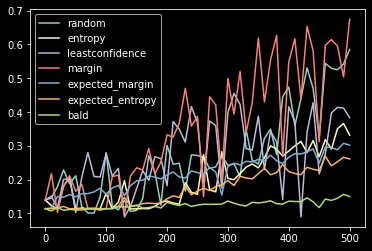

In [82]:
for k, v in results_dict.items():
    plt.plot(v["train_size"], v["test/accuracy_epoch"], label=k)
plt.legend()
plt.show()

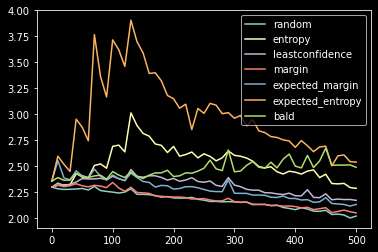

In [83]:
for k, v in results_dict.items():
    plt.plot(v["train_size"], v["test/loss_epoch"], label=k)
plt.legend()
plt.show()